# Customer Tape Analysis

##### Required column names: <br>
Total spend per transaction: 'total' <br>
Type of transaction: 'transaction_type' <br>
Customer id: 'customer_id' <br>
Customer created: 'customer_creation_date' <br>
Transaction date: 'order_transaction_date'

### Import all needed packages and set formatting

In [1]:
#Imports
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import xlsxwriter

#Formats
pd.set_option('display.precision',3)
pd.options.display.float_format = '{:.2f}'.format

### Functions to import and clean up data

In [48]:
#This function imports data, drops NA values, and parses dates
def import_data(file_name, before_year):
    #Import Data from CSV
    data = pd.read_csv(file_name, parse_dates=True, index_col='customer_id')
    
    #Drop nan values (drop row regardless of how many nans there are)
    data.dropna(axis=0,how='any',inplace=True)

    #Set dates to datetime format (this will speed up processing down the line)
    data['customer_creation_date']=pd.to_datetime(data['customer_creation_date'], format="%m/%d/%Y")
    data['order_transaction_date']=pd.to_datetime(data['order_transaction_date'], format="%m/%d/%Y")

    #Drop specific years (if needed)
    data = data[data['order_transaction_date'] < str(before_year)] 
    return data


#This function converts dates to periods (M/Q) and drops unnecessary columns
def convert_to_periods(data, freq, p_created, p_transacted):
    data[p_created]=pd.PeriodIndex(data.customer_creation_date, freq=freq)
    data[p_transacted]=pd.PeriodIndex(data.order_transaction_date, freq=freq)
    
    #Drop unnecessary columns
    data.drop(columns=['customer_creation_date','order_id','order_transaction_date'],inplace=True)
    return data

### Levers

In [49]:
file_name = 'flaviar^Mcaskers_orders_USD_2016-2020_PY.csv'

#set this value to a date in the future if you want all data
before_year = '2020'

#grouping into periods parameters. Set periods to 'M' if you want months
freq = 'Q'

p_created = str(freq+'_created')
p_transacted = str(freq+'_transacted')

### Call Functions

In [50]:
data = convert_to_periods(import_data(file_name, before_year), freq, p_created, p_transacted)

In [32]:
data = import_data(file_name,before_year)

## Data Aggregation and Calculation

### Function to get aggregate spends

In [ ]:
#Calculate sum, count, mean for every transaction type per period
#t_spends looks at total $ spent

def df_agg_spends(data):
    t_spends = pd.pivot_table(data,values=['total'], index=[p_transacted],columns=['transaction_type'],aggfunc=(np.sum,'count','mean'))
    #drop the TOTAL level
    t_spends.columns = t_spends.columns.droplevel()
    
    t_spends['% Memb Counts'] = t_spends['count']['MEMBERSHIP']/(t_spends['count']['RETAIL']+t_spends['count']['MEMBERSHIP'])
    t_spends['% Memb Sums'] = t_spends['sum']['MEMBERSHIP']/(t_spends['sum']['RETAIL']+t_spends['sum']['MEMBERSHIP'])
    
    return t_spends

In [ ]:
# Call the above function
t_spends = df_agg_spends(data)

### Plot the total spend data

In [ ]:
plot_data = t_spends

#fig, axes = plt.subplots(nrows=2, ncols=2)

plot_data.plot(y=['% Memb Counts','% Memb Sums'],
           figsize=(12,10),
           title='% of Total that are Memberships',
           label=['% Memb Counts','% Memb Sums'])

plot_data.plot(y='sum',
           figsize=(12,10),
           title='Sum of Spend per Period')

plot_data.plot(y='mean',
           figsize=(12,10),
           title='Average Spend per Period')

plot_data.plot(y='count',
           figsize=(12,10),
           title='Number of Transactions per Period')

### Function to get quantities purchased

In [ ]:
#t_quants looks at the quantity of items purchased
def df_agg_quants(data):
    t_quants = pd.pivot_table(data,values=['total_qty'], index=[p_transacted],columns=['transaction_type'],aggfunc=(np.sum,'count','mean'))
    t_quants.columns = t_quants.columns.droplevel()
    
    #calculate percent change values
    chg = t_quants.pct_change()
    return t_quants, chg

In [ ]:
t_quants, chg_rate = df_agg_quants(data)

In [ ]:
t_quants.plot(y=['sum','count'],figsize=(12,10),title='Total Number of Transactions and Order QTY Sum for R & M')
t_quants['mean'].plot(title='Mean Qty per Transaction', figsize=(12,10))

chg_rate.plot(title = 'MoM Change in Qty Sum and Transaction Qty', y =['sum','count'],figsize=(12,10))
plt.axhline(y=0,color='r')

chg_rate['mean'].plot(title = 'MoM Change in Mean Qty per Transaction',figsize=(12,10))
plt.axhline(y=0,color='r')

## Join the total_qty and total dataframes - optional <br>
Here we join the quantities and spends dataframes so we can pass the joined df to the excel writer later. This piece is optional

In [ ]:
joined = t_quants.reset_index().merge(t_spends.reset_index(),left_on=p_transacted,right_on=p_transacted)
joined = joined.set_index(p_transacted)

In [ ]:
joined = joined.rename(columns={'count_x':'Quantities Counts',
                  'mean_x':'Quantities Mean',
                  'sum_x':'Quantities Sums',
                  'count_y':'Totals Count',
                  'mean_y':'Totals mean',
                  'sum_y':'Totals Sums',
                  '% Memb Counts':'Totals % Memb Counts',
                  '% Memb Sums':'Totals % Memb Sums'})

## LTR (Lifetime Revenue) Distributions
#### This code looks at the distribution of spends across all customers. It is LTR because it does not account for S&M spend per period

In [ ]:
def get_ltr(data, c):
    ltr_df = pd.pivot_table(data,values=['total','total_qty'], index=['customer_id'],aggfunc=(np.sum,'count','mean'))
    ltr_df.columns = list(map("_".join, ltr_df.columns))
    ltr_df.drop(columns='total_qty_count',inplace=True)
    ltr_df.rename(columns={"total_count":'Number_Transactions',
                          "total_mean":"Average_Order_Value",
                          "total_sum":"Total_Amount_Spent",
                          "total_qty_mean":"Average_Items_Per_Order",
                          "total_qty_sum":"Total_Number_Items"},inplace = True)
    
    ltr_df.sort_values(c,ascending=False, inplace=True)
    
    #clip bottom .005 and top .005 (outliers)
    norm = ltr_df[(ltr_df[c] < ltr_df[c].quantile(.995)) & (ltr_df[c] > ltr_df[c].quantile(0.005))]
    top_five = ltr_df[(ltr_df[c] > ltr_df[c].quantile(0.95))]
    
#    abnorm = ltr_df[(ltr_df[c] > ltr_df[c].quantile(0.995)) | (ltr_df[c] < ltr_df[c].quantile(0.005))]
    
    return ltr_df, norm, top_five #abnorm

def get_hist_data(df,column,bins):
    m = df[column].max()
#   bins = np.arange(0, m, m/intervals).tolist()
    
    hist_df = df[column].value_counts(bins=bins)
    hist_df = hist_df.to_frame().sort_index(ascending = True)
    return hist_df

In [ ]:
#c is the column by which we will sort the df and normalize our data. Make sure this matches
#the new name of the column (i.e. Total_Amount_Spent rather than total_sum)
c = "Total_Amount_Spent"

ltr_df, norm, top_five = get_ltr(data, c)

ltr_df_hist = get_hist_data(ltr_df,c,1000)
norm_hist = get_hist_data(norm,c,100)

In [ ]:
retail_data = data[data['transaction_type']=='RETAIL']
memb_data = data[data['transaction_type']=='MEMBERSHIP']

In [ ]:
ltr_retail, r_norm, top_r_five = get_ltr(retail_data,c)
ltr_memb, m_norm, top_m_five = get_ltr(memb_data,c)

#Get histograms. For retail we use the normalized dataset, for memberships full dataset
ltr_retail_norm_hist = get_hist_data(r_norm,c,1000)
ltr_memb_hist = get_hist_data(ltr_memb,c,100)

#### From the above, we get the following key dataframes: <br>
ltr_df, norm, top_five (lifetime revenue per customer: ltr_df - all, norm - normalized, abnorm - abnormal) <br>
ltr_df_hist, norm_hist (histograms in the form of tables (data to plot)) <br>
ltr_retail, ltr_memb (lifetime revenue for retail and memberships separately)

Specifically, we will write top_five, ltr_df_hist, norm_hist, ltr_retail, ltr_memb, ltr_retail_norm_hist, and ltr_memb_hist

#### These dataframes will be added to the excel sheet later on

### Plotting histograms <br>
For plotting we will only use: ltr_retail, ltr_memb, ltr_df, and norm <br>
For excel writing we will use: ltr_df_hist, norm_hist, top_five

In [ ]:
def plot_data()

norm_hist.plot(kind='bar',figsize = (20,10))

In [ ]:
ltr_df.hist(column=c,bins=1000,figsize=(20,10),rwidth=0.9,xlabelsize=10)
plt.xlim(0,2000)
plt.title('Histogram of Spends')
plt.xlabel('Amount Spent')
plt.ylabel('Number of Users')

norm.hist(column=c,bins=100,figsize=(20,10),rwidth=0.9,xlabelsize=10)
plt.xlim(0,2000)
plt.title('Histogram of Spends - Normalized')
plt.xlabel('Amount Spent')
plt.ylabel('Number of Users')

## Mapping

In [92]:
from pygeocoder import Geocoder
import geopandas as gpd
import pgeocode
from shapely.geometry import Point, Polygon

from uszipcode import SearchEngine

In [360]:
#takes out non-US and invalid zip codes
def format_to_mapper(data):  
    data = data[data['zip'].astype(str).str.isdigit()]
    data = data[data['zip'].apply(lambda x: len(str(x)) > 4 & len(str(x)) < 8)]
    return data

#returns dataframe with a new column "states" that shows state of the zip code
def zip_to_state(data):
    search=SearchEngine(simple_zipcode=True)
    states=[]
    for index,row in data.iterrows():
        states.append(search.by_zipcode(row['zip']).state)
        print(row['zip'])
    data['state']=states
    return data


def zip_to_city(data):
    search=SearchEngine(simple_zipcode=True)
    cities=[]
    for index,row in data.iterrows():
        cities.append(search.by_zipcode(row['zip']).city)
        print(row['zip'])
    data['city']=cities
    return data

def load_map():
    #load a basemap of the US. map will be stored as country
    shapefile = "gz_2010_us_040_00_5m.json"
    country = gpd.read_file(shapefile)
    return country

def replace_states(country):
    us_state_abbrev = {
        'Alabama': 'AL',
        'Alaska': 'AK',
        'Arizona': 'AZ',
        'Arkansas': 'AR',
        'California': 'CA',
        'Colorado': 'CO',
        'Connecticut': 'CT',
        'Delaware': 'DE',
        'District of Columbia': 'DC',
        'Florida': 'FL',
        'Georgia': 'GA',
        'Hawaii': 'HI',
        'Idaho': 'ID',
        'Illinois': 'IL',
        'Indiana': 'IN',
        'Iowa': 'IA',
        'Kansas': 'KS',
        'Kentucky': 'KY',
        'Louisiana': 'LA',
        'Maine': 'ME',
        'Maryland': 'MD',
        'Massachusetts': 'MA',
        'Michigan': 'MI',
        'Minnesota': 'MN',
        'Mississippi': 'MS',
        'Missouri': 'MO',
        'Montana': 'MT',
        'Nebraska': 'NE',
        'Nevada': 'NV',
        'New Hampshire': 'NH',
        'New Jersey': 'NJ',
        'New Mexico': 'NM',
        'New York': 'NY',
        'North Carolina': 'NC',
        'North Dakota': 'ND',
        'Northern Mariana Islands':'MP',
        'Ohio': 'OH',
        'Oklahoma': 'OK',
        'Oregon': 'OR',
        'Palau': 'PW',
        'Pennsylvania': 'PA',
        'Puerto Rico': 'PR',
        'Rhode Island': 'RI',
        'South Carolina': 'SC',
        'South Dakota': 'SD',
        'Tennessee': 'TN',
        'Texas': 'TX',
        'Utah': 'UT',
        'Vermont': 'VT',
        'Virgin Islands': 'VI',
        'Virginia': 'VA',
        'Washington': 'WA',
        'West Virginia': 'WV',
        'Wisconsin': 'WI',
        'Wyoming': 'WY',}
    country=country.replace({"NAME": us_state_abbrev})
    return country

def merge_data_country(country,data):
    merged=country.set_index('NAME').join(data.set_index('NAME'))
    return merged

### Market Entry Analysis

In [361]:
def group_by_loc(data,scope):
    grouped_by_loc = pd.pivot_table(data, values = ['total'],columns = ['Q_transacted'], index = [scope],aggfunc='sum')
    grouped_by_loc.columns = grouped_by_loc.columns.droplevel()
    return grouped_by_loc.reset_index()

def group_by_loc2(data,scope):
    grouped_by_loc = pd.pivot_table(data, index = [[scope],'zip'])
    return grouped_by_loc.reset_index()

In [ ]:
scope = 'zip'
geo_data = zip_to_state(group_by_loc(format_to_mapper(data),scope))

In [363]:
scope = 'zip'
geo_data = zip_to_city(group_by_loc(format_to_mapper(data),scope))

0
10000
100000
10001
10002
10003
10004
10005
10006
10007
10009
10010
100102
10011
10012
10013
10014
10016
10017
10018
10019
10020
10021
10022
10023
10024
10025
10026
10027
10028
10029
10030
10031
100316028
10032
10033
10034
10035
10036
10037
10038
10039
10040
10041
10044
10055
10065
10069
10075
10103
10104
10105
10106
10107
10110
10111
10112
10115
10118
10119
10120
10121
10128
10151
10152
10153
10154
10155
10158
10162
10165
10166
10167
10168
10169
10170
10171
10172
10174
10175
10176
10177
10178
10245
10271
10278
10279
10280
10281
10282
10285
10286
10289
10301
10302
10303
10304
10305
10306
10307
10308
10309
10310
10312
10313
10314
10315
10390
10395
10439
10451
10452
10453
10454
10455
10456
10457
10458
10459
10460
10461
10462
10463
10464
10465
10466
10467
10468
10469
10470
10471
10472
10473
10474
10475
10501
10502
10504
10505
10506
10507
10509
10510
10511
10512
10514
10516
10520
10522
10523
10524
10528
10530
10532
10533
10536
10537
10538
10541
10543
10545
10546
10547
10548
10549
10550
10

In [366]:
xc = pd.pivot_table(geo_data,index='city',aggfunc='sum')

In [369]:
xc = xc.transpose()
xc[ xc==0 ] = np.nan

In [371]:
xc[ xc==0 ] = np.nan

In [377]:
xc['Abbeville'].first_valid_index()

Period('2016Q1', 'Q-DEC')

In [382]:
xcc=xc.reset_index()
xcc

city,Q_transacted,Abbeville,Aberdeen,Aberdeen Proving Ground,Abilene,Abingdon,Abiquiu,Abita Springs,Acampo,Accokeek,...,Zephyr Cove,Zephyrhills,Zillah,Zimmerman,Zion,Zionsville,Zionville,Zirconia,Zolfo Springs,Zuni
0,2016Q1,nan,493.06,nan,nan,397.93,nan,60.00,nan,nan,...,nan,nan,nan,nan,nan,212.95,nan,nan,nan,60.00
1,2016Q2,nan,274.95,nan,nan,238.97,nan,336.93,nan,60.00,...,nan,nan,nan,nan,60.00,nan,nan,nan,nan,60.00
2,2016Q3,nan,194.96,nan,nan,300.00,nan,144.98,nan,171.99,...,nan,100.99,nan,nan,60.00,161.99,nan,nan,nan,nan
3,2016Q4,60.00,550.91,nan,nan,450.96,nan,nan,nan,180.00,...,nan,60.00,nan,nan,246.98,420.00,186.98,nan,nan,nan
4,2017Q1,164.53,376.94,nan,113.99,673.90,nan,nan,210.00,60.00,...,nan,354.11,nan,nan,180.00,529.93,60.00,nan,60.00,nan
5,2017Q2,164.98,576.95,nan,60.00,336.97,nan,nan,84.98,89.98,...,nan,nan,nan,nan,153.99,593.97,nan,nan,60.00,nan
6,2017Q3,355.98,619.92,nan,108.99,124.97,nan,nan,nan,185.92,...,nan,60.00,nan,nan,60.00,1114.91,nan,nan,60.00,nan
7,2017Q4,265.98,1089.93,51.99,60.00,1191.99,nan,nan,540.00,64.97,...,nan,190.95,nan,452.99,120.00,1393.90,nan,nan,101.72,nan
8,2018Q1,337.98,728.91,375.86,nan,614.99,nan,nan,298.39,nan,...,nan,329.64,nan,nan,60.00,955.94,nan,nan,60.00,nan
9,2018Q2,65.99,1217.94,nan,nan,840.00,nan,nan,nan,nan,...,nan,240.00,530.94,240.00,nan,2450.80,nan,nan,60.00,nan


In [399]:
xcr = xc.transpose()
for index,row in xcr.iterrows():
    if row.sum()<100000:
        xcr.drop(index,inplace=True)
#for index,row in xcr.iterrows():
#    if 

In [400]:
print(len(xcr),len(xc.transpose()))

76 8244


In [ ]:
xcr.transpose()

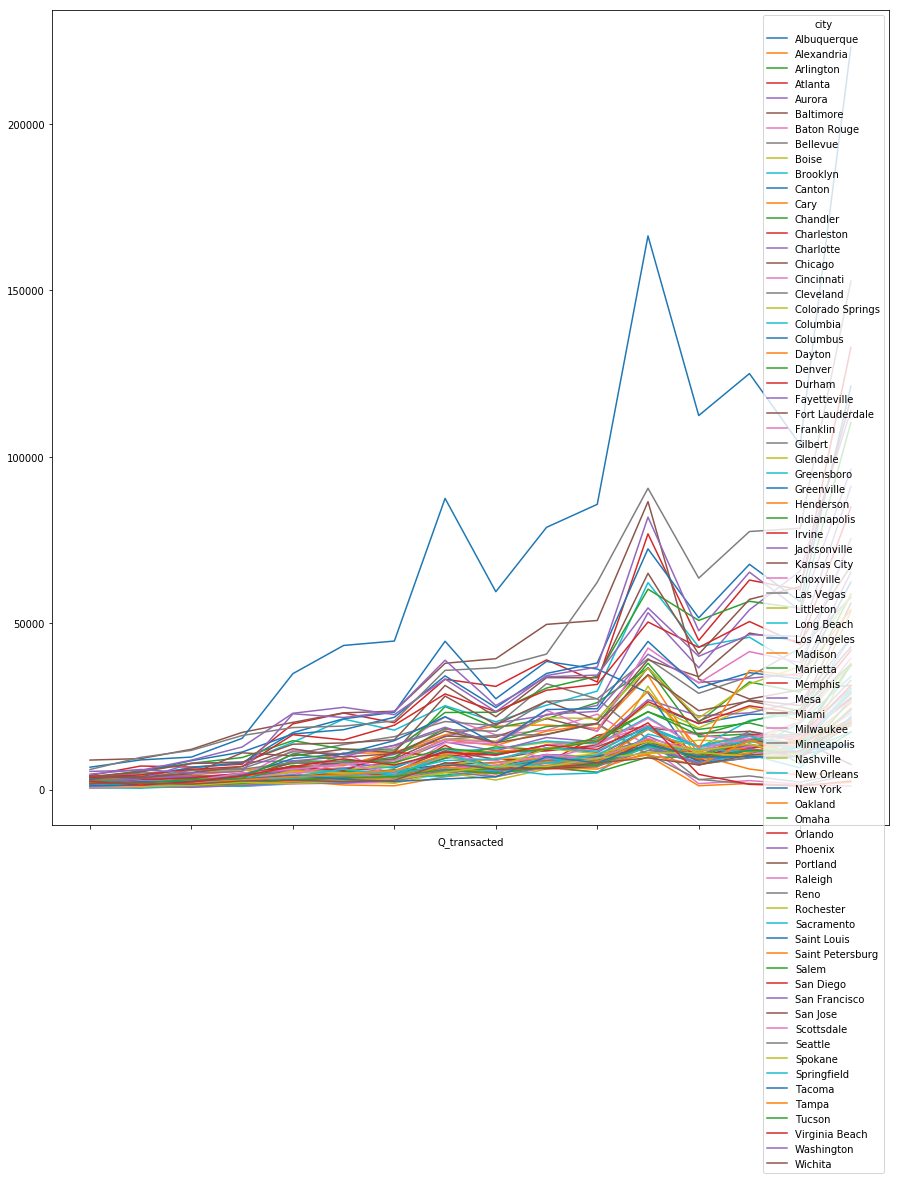

In [401]:
xcr.transpose().plot(figsize=(15,15))

In [388]:
xcr.sum(1)

city
Abbeville                  4080.90
Aberdeen                  17519.01
Aberdeen Proving Ground     961.35
Abilene                    1343.45
Abingdon                  10664.85
Abiquiu                     257.49
Abita Springs              1521.35
Acampo                     6301.25
Accokeek                   3309.82
Ackerman                    216.99
Acra                        148.22
Acton                      3606.05
Acworth                   27832.66
Ada                        7633.20
Adair                       273.11
Adairsville                1779.06
Adams                      3270.29
Adamstown                  1290.60
Adamsville                  336.98
Addieville                  247.98
Addis                      1893.17
Addison                    3169.62
Adel                       1741.11
Adelanto                   3375.13
Adrian                     9572.75
Advance                    4516.70
Afton                      2711.64
Agoura Hills              21343.74
Aguanga        

In [324]:
x = pd.pivot_table(geo_data,index = 'state', aggfunc = 'sum').transpose()

In [333]:
m = x.sum(axis = 0).sort_values(ascending = False)

In [344]:
M = x.drop(axis = 0,columns =['AL','AK','AL', 'AR', 'DE', 'HI', 'IA', 'ID', 'IL', 'KY', 'MD', 'MI', 'MN', 'MS', 'MT', 'ND', 'OH', 'OK', 'PA', 'PR', 'SD', 'TX', 'UT', 'VA', 'WV', 'WY'])

In [347]:
pct=M.pct_change()

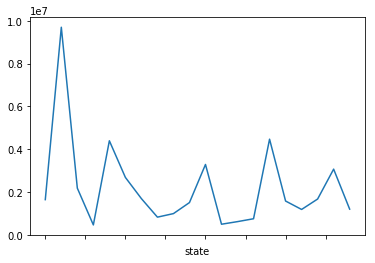

In [356]:
M['sums']sum().plot()

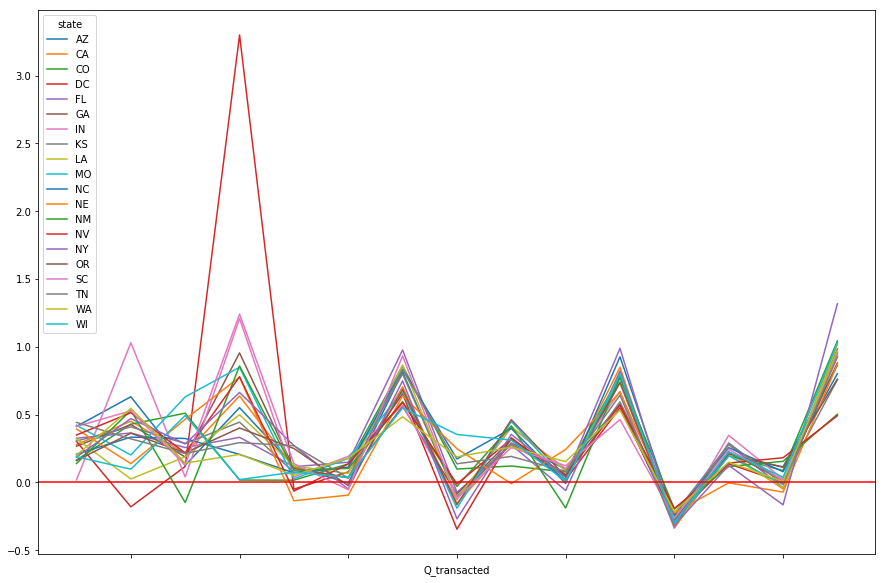

In [353]:
pct.plot(figsize=(15,10))
plt.axhline(y=0, color='r', linestyle='-')

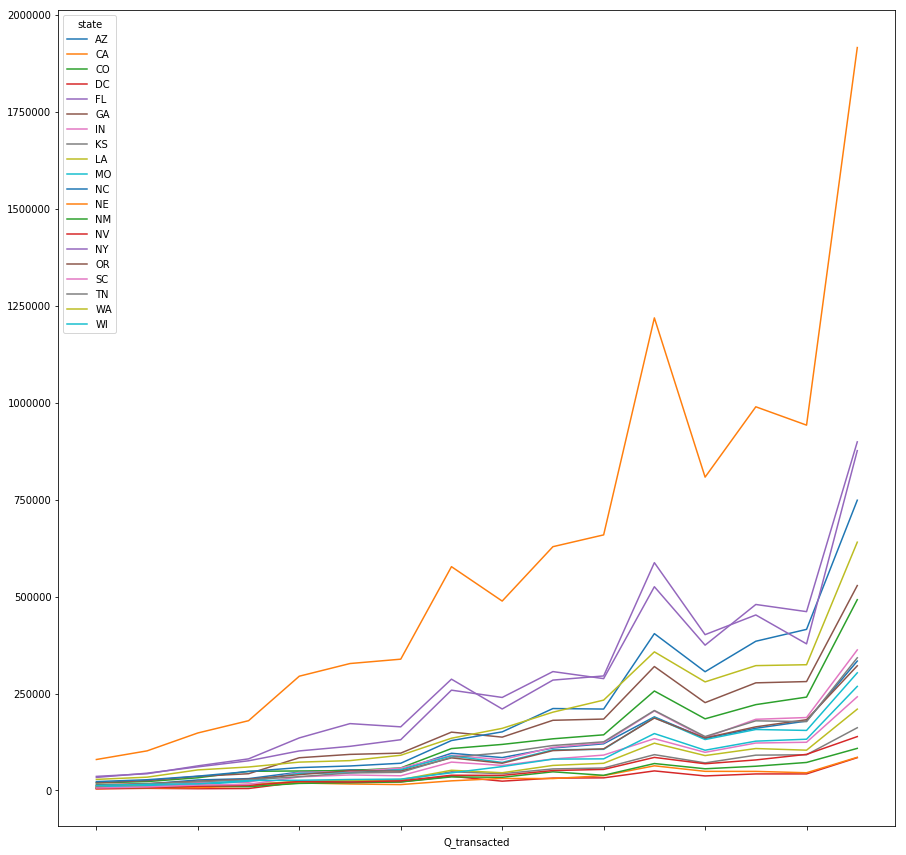

In [346]:
M.plot(figsize=(15,15))

In [340]:
low = x.drop(axis = 1, columns = ['CA','NY','FL','NC','WA',''])

merged = merged.drop(['AL','AK','AL', 'AR', 'DE', 'HI', 'IA', 'ID', 'IL', 'KY', 'MD', 'MI', 'MN', 'MS', 'MT', 'ND', 'OH', 'OK', 'PA', 'PR', 'SD', 'TX', 'UT', 'VA', 'VT', 'WV', 'WY'])

state,AK,AL,AR,AZ,CA,CO,DC,DE,FL,GA,...,SC,SD,TN,TX,UT,VA,WA,WI,WV,WY
Q_transacted,,,,,,,,,,,,,,,,,,,,,
2016Q1,1021.74,39.99,0.00,11746.68,79822.38,19616.78,4194.98,0.00,33593.44,20088.81,...,6420.77,49.99,11857.85,932.88,149.99,31990.36,28539.69,13174.56,2874.46,2553.54
2016Q2,294.96,240.00,180.98,16602.78,102115.13,22861.13,5465.21,60.00,44566.47,25457.80,...,9070.75,60.00,17113.85,1818.00,120.00,37410.44,34271.51,15676.90,4367.44,2215.66
2016Q3,0.00,0.00,0.00,27093.42,148280.09,32682.24,4486.43,0.00,60835.01,36335.73,...,13863.78,0.00,22621.19,180.00,0.00,43927.33,52986.63,17214.15,5177.53,4359.56
2016Q4,240.00,300.00,240.00,30528.17,179946.46,49380.68,5015.46,0.00,76503.17,43152.98,...,15650.85,120.00,27463.70,1252.98,0.00,58527.66,60541.20,25711.02,6520.51,4941.63
2017Q1,60.00,13998.85,2606.01,47364.95,294707.93,50268.76,21560.87,0.00,101973.00,84379.01,...,35076.10,118.98,35527.45,725.96,0.00,98544.37,73082.25,26251.82,10172.22,9528.17
2017Q2,0.00,16659.77,3300.10,53127.22,327391.38,51124.03,20497.10,120.00,113842.34,93050.47,...,39955.94,0.00,45147.25,1980.00,0.00,109590.58,76939.83,28254.93,11705.67,10684.07
2017Q3,0.00,8349.41,1180.61,52851.94,338612.33,58103.74,22098.32,0.00,130853.98,96305.52,...,37827.20,0.00,46647.70,1110.00,0.00,121618.31,90779.37,29332.90,13292.48,8776.35
2017Q4,120.00,3700.25,4835.93,95942.06,577239.91,108063.13,36553.93,480.00,258690.10,150427.05,...,73147.68,876.83,85483.28,4494.97,240.00,210401.17,134724.58,45457.06,27501.01,12888.63
2018Q1,210.00,321.57,2500.45,84769.47,488519.11,118759.36,23969.01,56.98,239916.39,137551.91,...,64584.54,655.87,97252.85,787.96,240.00,201237.56,160164.67,61551.90,24119.90,15471.67


In [339]:
m

state
CA   9699947.04
NY   4470474.74
FL   4396189.85
NC   3289629.47
WA   3071310.49
GA   2684999.13
MI   2291284.53
CO   2183225.07
OH   2141127.83
VA   2063676.22
IL   1791250.19
IN   1693932.08
TN   1675269.76
AZ   1647106.08
OR   1581916.75
MO   1509842.99
MD   1487505.96
WI   1203178.40
SC   1188197.65
LA    994541.93
KS    829130.43
NV    754311.67
NM    620022.52
IA    598565.26
NE    498298.44
DC    466041.68
MN    465643.56
ID    448901.97
WV    246092.86
MT    205003.89
MS    151344.21
WY    146652.51
AL     51040.91
TX     43094.74
AR     32959.23
PA     32442.01
OK     32062.93
HI      9058.57
SD      7701.54
KY      7588.47
UT      4913.18
ND      4400.20
AK      3632.59
DE      2965.87
PR      2074.98
dtype: float64

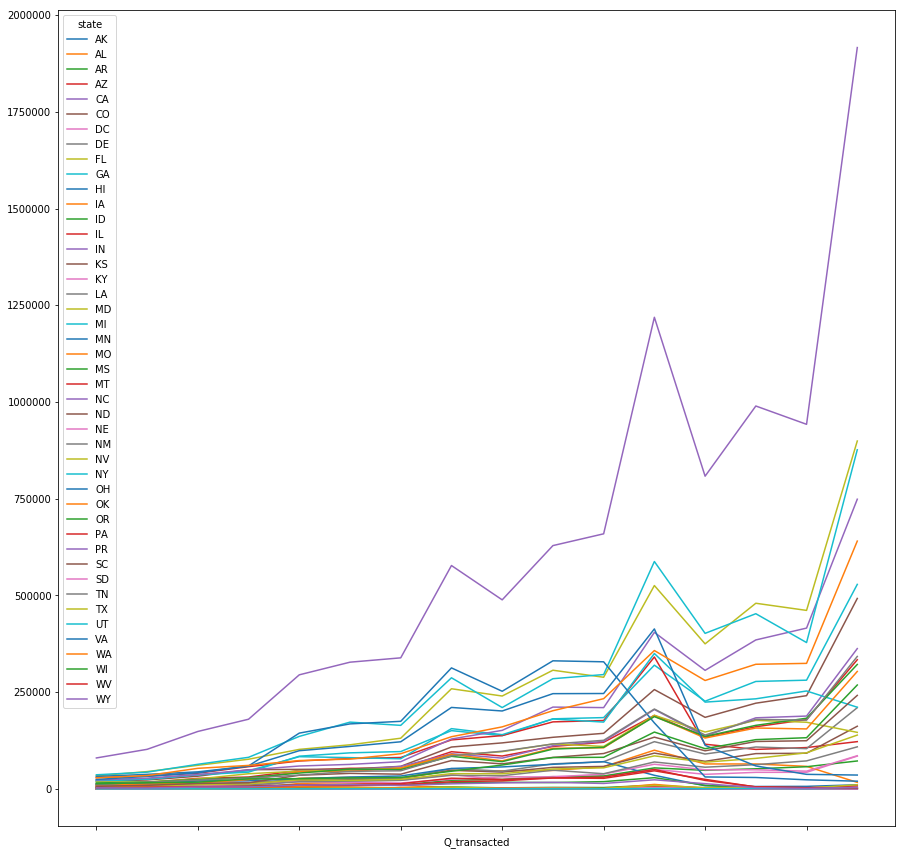

In [328]:
x.plot(figsize=(15,15))

In [289]:
x = m.first()
x.drop(columns = 'zip',inplace = True)
x = x.transpose()
#x = x.apply(lambda series: series.first_valid_index())

In [292]:
x

state,AK,AL,AR,AZ,CA,CO,DC,DE,FL,GA,...,SC,SD,TN,TX,UT,VA,WA,WI,WV,WY
Q_transacted,,,,,,,,,,,,,,,,,,,,,
2016Q1,24.99,39.99,nan,39.99,56.98,60.00,37.59,nan,64.26,46.99,...,39.99,49.99,57.88,99.99,149.99,32.70,38.99,125.98,39.99,85.76
2016Q2,60.00,60.00,120.00,39.99,60.00,66.66,51.66,60.00,113.98,49.42,...,48.24,60.00,60.00,120.00,120.00,24.99,48.33,59.99,36.99,58.82
2016Q3,nan,nan,nan,142.28,66.47,86.03,60.00,nan,60.00,60.00,...,40.00,nan,63.00,60.00,nan,51.25,60.00,60.00,83.98,51.54
2016Q4,60.00,240.00,120.00,60.00,219.05,58.16,52.59,nan,65.32,51.00,...,60.00,120.00,60.00,60.00,nan,56.75,60.00,59.75,48.00,84.77
2017Q1,60.00,254.92,217.95,69.75,41.41,60.00,136.81,nan,60.00,60.00,...,76.48,58.98,54.50,120.00,nan,65.99,53.99,54.40,44.49,90.88
2017Q2,nan,138.97,36.98,91.28,99.52,60.00,138.33,120.00,60.00,56.50,...,120.49,nan,100.00,120.00,nan,140.59,87.23,159.99,76.32,59.09
2017Q3,nan,73.98,64.97,102.49,133.47,86.36,111.57,nan,60.00,60.00,...,159.99,nan,58.00,60.00,nan,56.99,77.15,60.00,64.97,69.73
2017Q4,120.00,44.99,355.96,85.00,63.98,75.50,158.36,240.00,55.08,60.00,...,67.97,159.96,130.99,60.00,240.00,146.49,56.66,202.47,63.98,102.69
2018Q1,210.00,60.00,47.98,60.00,60.00,50.91,135.71,56.98,160.00,133.17,...,210.00,75.98,210.00,120.00,240.00,88.49,80.13,95.99,206.96,130.59


In [274]:
pivotz

zip                  28518-7667   55066-5630   55355-2155   98671-2242  &5331  \
      Q_transacted                                                              
total 2016Q1                nan          nan          nan          nan    nan   
      2016Q2                nan          nan          nan          nan    nan   
      2016Q3                nan          nan          nan          nan    nan   
      2016Q4                nan          nan          nan          nan    nan   
      2017Q1                nan          nan          nan          nan    nan   
      2017Q2                nan          nan          nan          nan    nan   
      2017Q3                nan          nan          nan          nan    nan   
      2017Q4                nan          nan        49.98          nan    nan   
      2018Q1                nan          nan          nan          nan    nan   
      2018Q2                nan          nan          nan          nan    nan   
      2018Q3                nan          nan          nan          nan    nan   
      2018Q4                nan          nan          nan        58.99    nan   
      2019Q1                nan          nan          nan          nan    nan   
      2019Q2                nan          nan          nan          nan    nan   
      2019Q3                nan          nan          nan          nan  60.00   
      2019Q4              66.48        97.81          nan          nan    nan   

zip                 )USA)  *****  -6302  ..20155      0   ...    apo ae 09227  \
      Q_transacted                                        ...                   
total 2016Q1          nan    nan    nan      nan    nan   ...           24.99   
      2016Q2          nan    nan    nan      nan    nan   ...             nan   
      2016Q3          nan    nan    nan      nan    nan   ...             nan   
      2016Q4          nan    nan    nan      nan    nan   ...             nan   
      2017Q1          nan    nan    nan      nan    nan   ...             nan   
      2017Q2          nan    nan    nan    89.50    nan   ...             nan   
      2017Q3          nan    nan    nan    94.50    nan   ...             nan   
      2017Q4          nan    nan    nan      nan    nan   ...             nan   
      2018Q1          nan    nan    nan      nan  60.00   ...             nan   
      2018Q2          nan    nan    nan      nan    nan   ...             nan   
      2018Q3          nan    nan    nan      nan    nan   ...             nan   
      2018Q4          nan  79.98    nan      nan    nan   ...             nan   
      2019Q1       119.50  60.00    nan      nan    nan   ...             nan   
      2019Q2          nan    nan 210.00      nan    nan   ...             nan   
      2019Q3          nan 210.00    nan      nan    nan   ...             nan   
      2019Q4          nan    nan    nan      nan 300.00   ...             nan   

zip                 dsadasda  gore    mi  nj07726  nr5 0sw  us, 12303  \
      Q_transacted                                                      
total 2016Q1             nan   nan   nan      nan      nan        nan   
      2016Q2             nan   nan   nan      nan      nan        nan   
      2016Q3             nan   nan 60.00      nan      nan        nan   
      2016Q4             nan   nan   nan      nan      nan        nan   
      2017Q1             nan   nan   nan      nan      nan        nan   
      2017Q2             nan 69.98   nan      nan      nan        nan   
      2017Q3             nan   nan   nan      nan      nan        nan   
      2017Q4             nan   nan   nan      nan      nan        nan   
      2018Q1             nan   nan   nan      nan      nan        nan   
      2018Q2             nan   nan   nan      nan      nan        nan   
      2018Q3             nan   nan   nan      nan    60.00        nan   
      2018Q4             nan   nan   nan      nan      nan      68.77   
      2019Q1             nan   nan   nan   144.98      nan  

In [237]:
x = zip_to_state(x)

In [213]:
scope = 'zip'
geo_dataz = format_to_mapper(data)
geo_dataz = group_by_loc(geo_dataz,scope)

In [223]:
x = geo_dataz.head(1000)
x = zip_to_state(x)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


KeyError: ''

In [118]:
pivotz = pivot_zips.transpose()

In [128]:
first_idx = pivotz[' 28518-7667'].first_valid_index()
last_idx = pivotz.last_valid_index()

In [131]:
pivotz.apply(lambda series: series.first_valid_index())

zip
 28518-7667         (total, 2019Q4)
 55066-5630         (total, 2019Q4)
 55355-2155         (total, 2017Q4)
 98671-2242         (total, 2018Q4)
&5331               (total, 2019Q3)
)USA)               (total, 2019Q1)
*****               (total, 2018Q4)
-6302               (total, 2019Q2)
..20155             (total, 2017Q2)
0                   (total, 2018Q1)
0&053               (total, 2019Q2)
00957-6803          (total, 2016Q1)
00969-5245          (total, 2018Q1)
01027-1510          (total, 2019Q4)
01453-1742          (total, 2019Q2)
01473-1220          (total, 2019Q3)
01510-1319          (total, 2019Q2)
01720-5414          (total, 2019Q4)
01748-1699          (total, 2019Q3)
01835-7832          (total, 2019Q2)
01880-3104          (total, 2019Q2)
01887-2755          (total, 2019Q3)
02-123              (total, 2016Q3)
02053-4509          (total, 2019Q4)
02066-4315          (total, 2019Q3)
02090-1191          (total, 2019Q4)
02109-2605          (total, 2019Q4)
02118-2307          (tot

In [127]:
pivotz.columns

Index([' 28518-7667', ' 55066-5630', ' 55355-2155', ' 98671-2242', '&5331',
       ')USA)', '*****', '-6302', '..20155', '0',
       ...
       'apo ae 09227', 'dsadasda', 'gore', 'mi', 'nj07726', 'nr5 0sw',
       'us, 12303', 'us, 30815', 'us, 91352', 'v2n4e8'],
      dtype='object', name='zip', length=21017)

In [130]:
pivotz

zip                  28518-7667   55066-5630   55355-2155   98671-2242  &5331  \
      Q_transacted                                                              
total 2016Q1                nan          nan          nan          nan    nan   
      2016Q2                nan          nan          nan          nan    nan   
      2016Q3                nan          nan          nan          nan    nan   
      2016Q4                nan          nan          nan          nan    nan   
      2017Q1                nan          nan          nan          nan    nan   
      2017Q2                nan          nan          nan          nan    nan   
      2017Q3                nan          nan          nan          nan    nan   
      2017Q4                nan          nan        49.98          nan    nan   
      2018Q1                nan          nan          nan          nan    nan   
      2018Q2                nan          nan          nan          nan    nan   
      2018Q3                nan          nan          nan          nan    nan   
      2018Q4                nan          nan          nan        58.99    nan   
      2019Q1                nan          nan          nan          nan    nan   
      2019Q2                nan          nan          nan          nan    nan   
      2019Q3                nan          nan          nan          nan  60.00   
      2019Q4              66.48        97.81          nan          nan    nan   

zip                 )USA)  *****  -6302  ..20155      0   ...    apo ae 09227  \
      Q_transacted                                        ...                   
total 2016Q1          nan    nan    nan      nan    nan   ...           24.99   
      2016Q2          nan    nan    nan      nan    nan   ...             nan   
      2016Q3          nan    nan    nan      nan    nan   ...             nan   
      2016Q4          nan    nan    nan      nan    nan   ...             nan   
      2017Q1          nan    nan    nan      nan    nan   ...             nan   
      2017Q2          nan    nan    nan    89.50    nan   ...             nan   
      2017Q3          nan    nan    nan    94.50    nan   ...             nan   
      2017Q4          nan    nan    nan      nan    nan   ...             nan   
      2018Q1          nan    nan    nan      nan  60.00   ...             nan   
      2018Q2          nan    nan    nan      nan    nan   ...             nan   
      2018Q3          nan    nan    nan      nan    nan   ...             nan   
      2018Q4          nan  79.98    nan      nan    nan   ...             nan   
      2019Q1       119.50  60.00    nan      nan    nan   ...             nan   
      2019Q2          nan    nan 210.00      nan    nan   ...             nan   
      2019Q3          nan 210.00    nan      nan    nan   ...             nan   
      2019Q4          nan    nan    nan      nan 300.00   ...             nan   

zip                 dsadasda  gore    mi  nj07726  nr5 0sw  us, 12303  \
      Q_transacted                                                      
total 2016Q1             nan   nan   nan      nan      nan        nan   
      2016Q2             nan   nan   nan      nan      nan        nan   
      2016Q3             nan   nan 60.00      nan      nan        nan   
      2016Q4             nan   nan   nan      nan      nan        nan   
      2017Q1             nan   nan   nan      nan      nan        nan   
      2017Q2             nan 69.98   nan      nan      nan        nan   
      2017Q3             nan   nan   nan      nan      nan        nan   
      2017Q4             nan   nan   nan      nan      nan        nan   
      2018Q1             nan   nan   nan      nan      nan        nan   
      2018Q2             nan   nan   nan      nan      nan        nan   
      2018Q3             nan   nan   nan      nan    60.00        nan   
      2018Q4             nan   nan   nan      nan      nan      68.77   
      2019Q1             nan   nan   nan   144.98      nan  

In [102]:
pivot_zips.transpose()

0      1      2      3      4      5      6      7      \
      Q_transacted                                                           
total 2016Q1        24.99  24.99  96.97  21.99  69.00  24.99  49.99  33.32   
      2016Q2        24.99  60.00 128.47  60.00  38.65  60.00  60.00  39.99   
      2016Q3        36.99  46.99  60.00  60.00 131.63  60.00 409.94  60.00   
      2016Q4        60.00  84.50 143.97  60.00  60.00 181.64  60.00  24.99   
      2017Q1        60.00 211.97  99.98  60.00  60.00  60.00 230.64  60.00   
      2017Q2        89.50 138.97  60.00  60.00  60.00  60.00  60.00  60.00   
      2017Q3        94.50 210.00  60.00  60.00  60.00  60.00  60.00  24.99   
      2017Q4        49.98 139.98 240.00  60.00  60.00  60.00  67.41  24.99   
      2018Q1        60.00  60.00  60.00  60.00  24.99  60.00  84.00  60.98   
      2018Q2        52.98  24.99  60.00  89.54  77.98  60.00  60.00  60.00   
      2018Q3        60.00 239.21 126.00 137.25  89.30 110.72  80.58 143.91   
      2018Q4        58.99  79.98 153.98  66.97  48.98  80.97 166.95 239.98   
      2019Q1       119.50  60.00 140.98  66.97  98.25  67.97  77.98 123.68   
      2019Q2       210.00  60.00  68.42  57.79 191.27  75.85 116.23 110.98   
      2019Q3        60.00 210.00  27.79 101.35 225.91  73.54 331.73 249.92   
      2019Q4        66.48  97.81 300.00 178.40 158.10  77.79 225.48  99.91   

                    8      9      ...    11760  11761  11762  11763  11764  \
      Q_transacted                ...                                        
total 2016Q1        39.99  60.00  ...      nan    nan    nan    nan    nan   
      2016Q2        39.99  88.47  ...      nan    nan    nan    nan    nan   
      2016Q3        24.99  60.00  ...      nan    nan    nan    nan    nan   
      2016Q4       110.98  60.00  ...      nan    nan    nan    nan    nan   
      2017Q1        71.99 101.48  ...      nan    nan    nan    nan    nan   
      2017Q2        24.99  48.99  ...      nan    nan    nan    nan    nan   
      2017Q3        60.00  60.00  ...      nan    nan    nan    nan    nan   
      2017Q4        60.00 182.97  ...      nan    nan    nan    nan    nan   
      2018Q1        65.28  60.00  ...      nan    nan    nan    nan    nan   
      2018Q2        60.00 204.84  ...      nan    nan    nan    nan    nan   
      2018Q3       207.14 262.67  ...      nan    nan    nan    nan    nan   
      2018Q4        78.98 233.95  ...    74.44  60.00 124.98 100.98  60.00   
      2019Q1       120.47  67.97  ...      nan    nan    nan    nan    nan   
      2019Q2        49.94  57.41  ...      nan    nan    nan    nan    nan   
      2019Q3        90.23 100.46  ...      nan    nan    nan    nan    nan   
      2019Q4       145.79  52.29  ...      nan    nan    nan    nan    nan   

                    11765  11766  11767  11768  11769  
      Q_transacted                                     
total 2016Q1          nan    nan    nan    nan    nan  
      2016Q2          nan    nan    nan    nan    nan  
      2016Q3          nan    nan    nan    nan    nan  
      2016Q4          nan    nan    nan    nan    nan  
      2017Q1          nan    nan    nan    nan    nan  
      2017Q2          nan    nan    nan    nan    nan  
      2017Q3          nan    nan    nan    nan    nan  
      2017Q4          nan    nan    nan    nan    nan  
      2018Q1          nan    nan    nan    nan    nan  
      2018Q2          nan    nan    nan    nan    nan  
      2018Q3          nan    nan    nan    nan    nan  
      2018Q4       210.00 131.99 177.97  68.77 210.00  
      2019Q1          nan    nan    nan    nan    nan  
      2019Q2          nan    nan    nan    nan    nan  
      2019Q3          nan    nan    nan    nan    nan  
      2019Q4          nan    nan    nan    nan    nan  

[16 rows x 11770 columns]

In [54]:
pivotz=pivot_zips.transpose()
##pivot_zips = pivot_zips.apply(lambda x: pd.Series(x.dropna().values))

In [63]:
pivotz = pivotz.apply(lambda x: pd.Series(x.dropna().values))
pivotz = pivotz.transpose()

KeyboardInterrupt: 

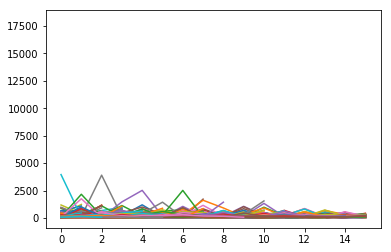

In [68]:
pivotz = pivotz.transpose()
pivotz.plot(kind='line')

In [78]:
pivotz['sum']=pivotz.sum(axis=1)
zips_sums = pivotz['sum']
zips_sums = zips_sums.to_frame()

In [80]:
zips_sums['pct_chg'] = zips_sums['sum'].pct_change()
#zips_sums['pct_chg'] = zips_sums['sum']
#chg = t_quants.pct_change()

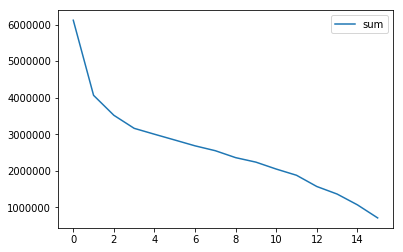

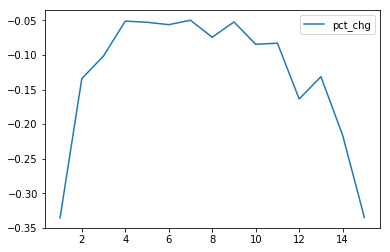

In [88]:
zips_sums.plot(y='sum')
zips_sums.plot(y='pct_chg')

In [358]:
zips_sums

,sum,pct_chg
0,6117228.23,nan
1,4062987.65,-0.34
2,3517327.49,-0.13
3,3160659.41,-0.10
4,2999381.47,-0.05
5,2841360.90,-0.05
6,2681850.17,-0.06
7,2548447.71,-0.05
8,2359004.33,-0.07
9,2235880.22,-0.05


## Now we save our outputs into an excel file

In [ ]:
#Create a new Excel file and add a worksheet

writer = pd.ExcelWriter('aggSumWriter.xlsx',engine='xlsxwriter')
ltr_memb_hist.to_excel(writer,encoding='utf8',sheet_name='ltr_memb_hist')

writer.save()

In [ ]:
#Create the workbook and worksheet objects
workbook = writer.book
worksheet = writer.sheets['sheet1']

In [ ]:
#Create a chart object
chart = workbook.add_chart({'type':'line'})

#Configure the series of the chart from the dataframe data
chart.add_series({'values':'=Sheet1!$G4:$G51'})

#Insert the chart into the worksheet
worksheet.insert_chart('D2',chart)

writer.save()

In [ ]:
x=chg_rate
x['diff_btw_sum_count']=x['sum']['MEMBERSHIP']-x['count']['MEMBERSHIP']

In [ ]:
x['diff_btw_sum_count']

In [ ]:
print("Maximum count:",ltr_df['count'].max())
print("Maximum spend:",ltr_df['sum'].max())

In [ ]:
quant_df.hist(column='sum',bins=1000,figsize=(20,8),rwidth=0.9,xlabelsize=10)
plt.xlim(0,50)

In [ ]:
changedM=pd.DataFrame(list,columns=['Memberships Sums','M Change Rate','R Sums','R Change Rate'])
#changedR=pd.DataFrame(listR,columns=['R Sums','R Change Rate'])
#frames=[changedM,changedR]

In [ ]:
changedM.plot()

In [ ]:
changedM.plot(y=['M Change Rate','R Change Rate'],title='Rate of Change in Total Spend')
plt.axhline(y=0,color='r')

In [ ]:
dict = {'Membership Change':listM,'Retail Change':listR}
changedf=pd.DataFrame(dict)

In [ ]:
changedf

In [ ]:
changedf.drop([16],axis=0).plot()

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2)

In [ ]:
calcs.plot(x=y =calcs['Sum']['RETAIL'], y='Stock_Index_Price', kind = 'scatter')

In [ ]:
plot_df=pd.DataFrame

In [ ]:
plot_df['%Memb Counts']=calcs['% Memb Counts']
plot_df['%Memb Sums']=calcs['% Memb Counts']

In [ ]:
by_trans.transpose()

In [ ]:
by_trans.transpose()
by_trans=pd.concat([by_trans['total']['count'],by_trans['total']['sum'],by_trans['total']['mean']],keys=['Count','Sum','Mean'])

In [ ]:
calcs=y.transpose()
calcs['Percentage Membership Counts']=calcs['Count']['MEMBERSHIP']/calcs['Count']['RETAIL']
calcs['Percentage Membership Sums']=calcs['Sum']['MEMBERSHIP']/calcs['Sum']['RETAIL']

In [ ]:
#no longer in use
by_dates = pd.pivot_table(data,values=['total'], index=['customer_id','transaction_type'],columns=['Q_transacted'],aggfunc=np.sum)

In [ ]:
#Spot check the data
y.sum(axis=1).apply(lambda x: '{:.2f}'.format(x))

In [ ]:
y=pd.concat([by_trans['total']['count'],by_trans['total']['sum'],by_trans['total']['mean']],keys=['Count','Sum','Mean'])

In [ ]:
y=y.apply(lambda x: '{:.2f}'.format(x))

In [ ]:
#Spot check the data
y.sum(axis=1).apply(lambda x: '{:.2f}'.format(x))

In [ ]:
x=by_trans['total']['count'].append(by_trans['total']['sum'])

In [ ]:
y=pd.concat([by_trans['total']['count'],by_trans['total']['sum']],keys=['Count','Sum'])

In [ ]:
data['period_created'] = data.customer_creation_date.apply(lambda x: x.strftime('%Y-%m') if x else "")
data['period_trans'] = data.order_transaction_date.apply(lambda x: x.strftime('%Y-%m') if x else "")

In [ ]:
data.drop(columns=['customer_creation_date','order_transaction_date'])

In [ ]:
x=data.groupby('customer_creation_date').resample('Q-JAN', convention='end').agg('mean')

In [ ]:
data.set_index(['customer_creation_date'],inplace=True,drop=False)

In [ ]:
data

## Extras - use if needed

In [ ]:
#calcs.drop('2020Q1',axis=0)
xm = calcs
xm=xm.reset_index().drop([16],axis=0).set_index('Q_transacted')

### FOR MAPPING

In [ ]:
#BELOW WAS USED FOR MAPPING
#Drop unneeded columns
#data = data.drop(columns=['currency','order_id','transaction_type','customer_creation_date','total_qty','total'])

#ZIP CODE FORMATTING
#Drop bad rows (where zip code is messed up or contains non numeric vals)
##data=data[data['zip'].astype(str).str.isdigit()]
#data.zip=data.zip.astype(int)
##data = data[data['zip'].apply(lambda x: len(str(x)) > 4)]
#$data = data[data['zip'].apply(lambda x: len(str(x)) < 8)]